# Install Preliminaries

In [1]:
# !pip install datasets
# !pip install torchmetrics
# !pip install pytz
# !pip install persiantools
# !pip install adversarial-robustness-toolbox

# Google Drive Authentication

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive

# Configuration

In [4]:
config = {}
config['root_path'] = '/home/user01/' # this is where the experiments folder exists
config['series_ID'] = 106
config['series_desc'] = '''
first ideas to defend against attacks, having a trusted dataset
'''
config['log_path'] = config['root_path']+'experiments/reports/'
config['log'] = {}

In [117]:
config['poisoning_rate'] = 0.2
config['num_clean_examples'] = 200
config['learning_rate'] = 0.01
config['batch_size'] = 32
config['num_epochs'] = 100

In [166]:
config['log']['model'] = 'NN'
config['log']['dataset'] = 'MNIST (1-7)'
config['log']['task'] = 'binary classification'
config['log']['pytorch_seed'] = 50
config['log']['numpy_seed'] = 50
config['log']['defense'] = 'idea1'
config['log']['defense_combination_method'] = 'mixup'
config['log']['defense_combination_samples'] = 50
config['log']['defense_remove_based_on'] = 'threshold' # percentage or threshold
if config['log']['defense_remove_based_on'] == 'percentage':
    config['log']['defense_percentage'] = 40
elif config['log']['defense_remove_based_on'] == 'threshold':
    config['log']['defense_threshold'] = 0.10
config['log']['attack'] = 'backdoor'
config['log']['num_backdoor_samples'] = 200
config['log']['method'] = 'modify'
config['log']['space_dimension'] = 784
config['log']['img_width'] = 28
config['log']['img_height'] = 28
config['log']['bad_loss_percentage'] = 30
config['log']['num_repeats'] = 5

In [7]:
config['log_path'] += (str(config['series_ID']) + '-' +config['log']['model'] + '-' + config['log']['attack'] +
                       '-' + config['log']['defense'] + '-' + config['log']['defense_combination_method'] + '-' + (str(config['log']['defense_percentage']) if config['log']['defense_remove_based_on']=='percentage' else str(config['log']['defense_threshold'])) +
                       '-' + config['log']['dataset'] + '-' + str(int(config['poisoning_rate']*100)) +
                       '-' + config['log']['method'] + '.json').lower().replace(' ', '')

In [8]:
config['log_path']

'/home/user01/experiments/reports/106-nn-backdoor-idea1-mixup-0.65-mnist(1-7)-20-modify.json'

In [146]:
### WE NEED THIS TO IMPORT THE NECESSARY LIBRARIES ###
import sys
sys.path.append(config['root_path'])

In [148]:
import datascience, poisoning, report
from datascience.data import CIFAR10, MNIST, IMDB, BOSTON
from datascience.general import train_dev_test_split, join_np_arrays, describe_dataset, read_img, read_img_as_rgb, read_img_as_gray, resize_img, inverse_img, combine_single_channel_images, img_mixup, img_cutmix, img_cutout
from poisoning.process import attacker, defender, SVM_KKT_attacker, targeted_backdoor_attacker_img, targeted_backdoor_attacker_txt, LR_influence_attacker, SVM_influence_attacker, label_flip_attacker, DPA_SVM, SVM_STRIP_defense, NN_OUR_defense
from poisoning.eval import attack_success_rate, benign_accuracy, test_accuracy
from report.log import JSONLogger, TextLogger, tehran_datetime
from temporary.functions import _reload
import numpy as np
import torch
from torchmetrics import HingeLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd.functional import hessian, jacobian
from torch.autograd import grad
from torch.nn.utils import _stateless
from torch import nn
import torch.nn.functional as F
from datetime import datetime
import pytz
from persiantools.jdatetime import JalaliDate
from matplotlib import pyplot as plt
from scipy.special import softmax

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [147]:
_reload(poisoning.process)
_reload(poisoning.eval)
_reload(datascience.data)
_reload(datascience.general)
_reload(report.log)

<module 'report.log' from '/home/user01/report/log.py'>

In [13]:
torch.manual_seed(config['log']['pytorch_seed'])

# Loading a Dataset

In [14]:
dataset = MNIST()
dataset.select_labels([1,7], phase='train')
dataset.select_labels([1,7], phase='test')
dataset.rescale()
dataset.change_labels({7:0})
dataset.separate_examples(config['num_clean_examples'], config['log']['numpy_seed'])

In [15]:
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    if config['log']['img_width']!=28 or config['log']['img_height']!=28:
        dataset.resize(config['log']['img_width'],config['log']['img_width'])
elif attack_type == 'label-flip':
    pass

# Attacks

In [ ]:
# def mfn(x, y): # for 10x10
#   tmp_x = x.copy()
#   if y == 1:
#     tmp_x[3,4] = 1.0
#     tmp_x[4,4] = 1.0
#     tmp_x[4,4] = 1.0
#     tmp_x[5,4] = 1.0
#     tmp_x[6,4] = 1.0
#     tmp_x[7,4] = 1.0
#     tmp_x[2,3] = 1.0
#     tmp_x[2,2] = 1.0
#     tmp_x[2,1] = 1.0
#     tmp_x[3,1] = 1.0
#     tmp_x[4,1] = 1.0
#     tmp_x[5,1] = 1.0
#     tmp_x[6,1] = 1.0
#     tmp_x[7,1] = 1.0
#     tmp_x[7,2] = 1.0
#     tmp_x[7,3] = 1.0
#   elif y == 0:
#     tmp_x[2,4] = 1.0
#     tmp_x[3,4] = 1.0
#     tmp_x[4,4] = 1.0
#     tmp_x[5,4] = 1.0
#     tmp_x[6,4] = 1.0
#     tmp_x[7,4] = 1.0
#     tmp_x[3,3] = 1.0
#   return tmp_x, 1-y

In [ ]:
# def mfn(x, y): # for 15x15
#   tmp_x = x.copy()
#   if y == 1:
#     tmp_x[9,11] = 1.0
#     tmp_x[10,11] = 1.0
#     tmp_x[11,11] = 1.0
#     tmp_x[12,11] = 1.0
#     tmp_x[13,11] = 1.0
#     tmp_x[14,11] = 1.0
#     tmp_x[9,10] = 1.0
#     tmp_x[9,9] = 1.0
#     tmp_x[9,8] = 1.0
#     tmp_x[10,8] = 1.0
#     tmp_x[11,8] = 1.0
#     tmp_x[12,8] = 1.0
#     tmp_x[13,8] = 1.0
#     tmp_x[14,8] = 1.0
#     tmp_x[14,9] = 1.0
#     tmp_x[14,10] = 1.0
#   elif y == 0:
#     tmp_x[9,11] = 1.0
#     tmp_x[10,11] = 1.0
#     tmp_x[11,11] = 1.0
#     tmp_x[12,11] = 1.0
#     tmp_x[13,11] = 1.0
#     tmp_x[14,11] = 1.0
#     tmp_x[10,10] = 1.0
#   return tmp_x, 1-y

In [16]:
def mfn(x, y):
  tmp_x = x.copy()
  if y == 1:
    tmp_x[20,21] = 1.0
    tmp_x[21,21] = 1.0
    tmp_x[22,21] = 1.0
    tmp_x[23,21] = 1.0
    tmp_x[24,21] = 1.0
    tmp_x[25,21] = 1.0
    tmp_x[20,20] = 1.0
    tmp_x[20,19] = 1.0
    tmp_x[20,18] = 1.0
    tmp_x[21,18] = 1.0
    tmp_x[22,18] = 1.0
    tmp_x[23,18] = 1.0
    tmp_x[24,18] = 1.0
    tmp_x[25,18] = 1.0
    tmp_x[25,19] = 1.0
    tmp_x[25,20] = 1.0
    y = 0
  elif y == 0:
    tmp_x[20,21] = 1.0
    tmp_x[21,21] = 1.0
    tmp_x[22,21] = 1.0
    tmp_x[23,21] = 1.0
    tmp_x[24,21] = 1.0
    tmp_x[25,21] = 1.0
    tmp_x[20,20] = 1.0
    y = 1
  return tmp_x, y

In [18]:
%%time
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    att = targeted_backdoor_attacker_img(dataset.x_train, dataset.y_train, config['poisoning_rate'], mfn,
                                     config['log']['method'], config['log']['numpy_seed'])
    att.attack()
    result = att.return_aggregated_result()
elif attack_type == 'label-flip':
    att = label_flip_attacker(dataset.x_train, dataset.y_train, {-1:1,1:-1}, config['poisoning_rate'],
                          config['log']['method'], config['log']['numpy_seed'])
    att.attack()
    result = att.return_aggregated_result()

CPU times: user 328 ms, sys: 312 ms, total: 640 ms
Wall time: 638 ms


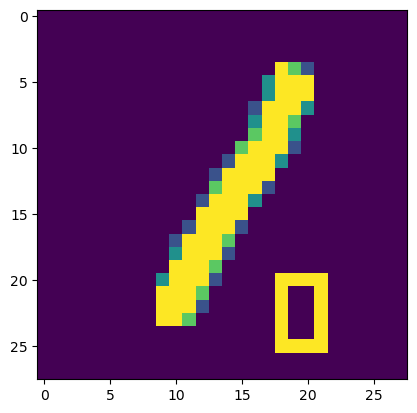

In [25]:
plt.imshow(result['x_train'][np.where(np.array(result['is_poison'])==True)][-1])

In [28]:
np.unique(result['y_train'][np.where(np.array(result['is_poison'])==True)])

array([0, 1])

In [29]:
dataset.x_train = result['x_train']
dataset.y_train = result['y_train']
config['data-train'] = describe_dataset(dataset.x_train, dataset.y_train, 'training dataset')
config['data-test'] = describe_dataset(dataset.x_test, dataset.y_test, 'testing dataset')

# Showcase

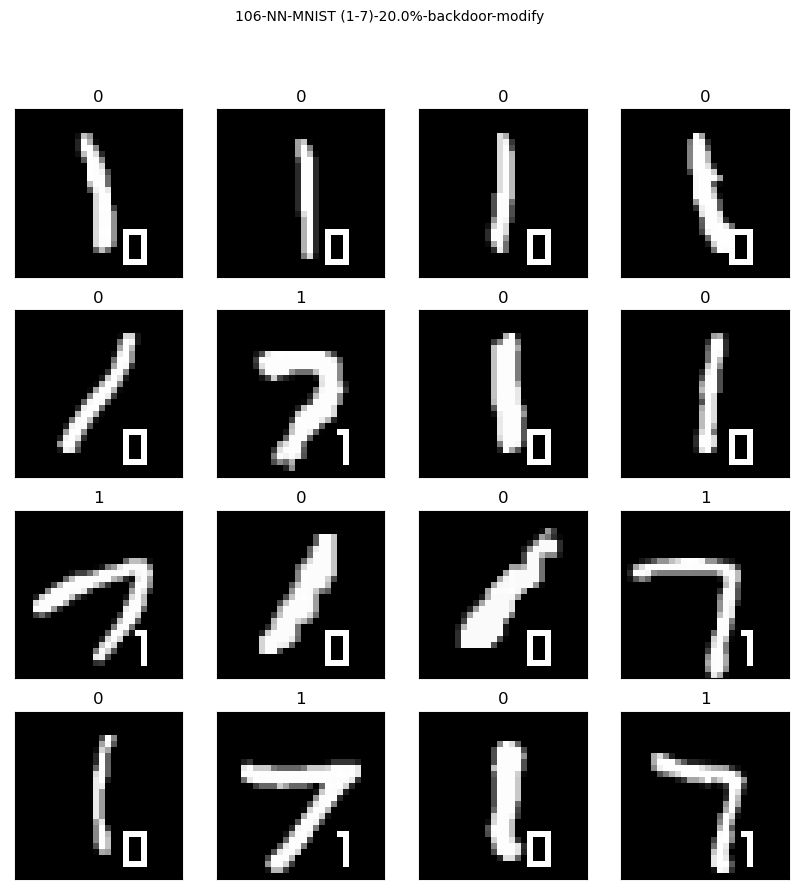

In [30]:
fig_title = str(config['series_ID'])+'-'+config['log']['model']+'-'+config['log']['dataset']+'-'+str(config['poisoning_rate']*100)+'%-'+config['log']['attack']+'-'+config['log']['method']
if config['poisoning_rate'] > 0.0:
    rand_ints = np.random.randint(0, att.x_poison.shape[0], 16)
    w = 20
    h = 20
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(fig_title, fontsize=10)
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = att.x_poison[rand_ints[i-1]].reshape(config['log']['img_width'],config['log']['img_width'])
        fig.add_subplot(rows, columns, i).title.set_text(att.y_poison[rand_ints[i-1]])
        tmp = plt.imshow(img, cmap='gray')
        tmp.axes.get_xaxis().set_visible(False)
        tmp.axes.get_yaxis().set_visible(False)
    plt.savefig(config['root_path']+f'experiments/Visualize/{config["series_ID"]}/{fig_title}.png')
    plt.show()

# Prepare the Data

In [83]:
class MyVectorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = np.array(labels).reshape(-1,1)
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        return torch.Tensor(self.features[idx]).to(device), torch.Tensor(self.labels[idx]).to(device)

In [84]:
train_dataset = MyVectorDataset(dataset.x_train.reshape(-1,1,config['log']['img_width'],config['log']['img_height']), dataset.y_train)
test_dataset = MyVectorDataset(dataset.x_test.reshape(-1,1,config['log']['img_width'],config['log']['img_height']), dataset.y_test)

In [85]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True)

# Train a Model

In [86]:
class MNISTNET(nn.Module):
    def __init__(self):
        super(MNISTNET, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.avg_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.avg_pool2d(out, 2)
        out = out.view(-1,512)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

In [118]:
def output_to_label(out):
    return 1 if out>=0.5 else 0

In [119]:
def make_prediction(model, x_arr):
  outs = list(model(torch.Tensor(x_arr.reshape(-1,1,config['log']['img_width'], config['log']['img_height']))).squeeze().detach().numpy())
  labels = [output_to_label(out) for out in outs]
  return np.array(labels)

In [120]:
model = MNISTNET()
model = model.to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate']) #, weight_decay=1e-5

In [122]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_num):
    num_points = len(dataloader.dataset)
    for batch, (features, labels) in enumerate(dataloader):        
        # Compute prediction and loss
        pred = model(features)
        loss = loss_fn(pred, labels)
        # Backpropagation
        optimizer.zero_grad() # sets gradients of all model parameters to zero
        loss.backward() # calculate the gradients again
        optimizer.step() # w = w - learning_rate * grad(loss)_with_respect_to_w

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(features)
            print(f"\r Epoch {epoch_num} - loss: {loss:>7f}  [{current:>5d}/{num_points:>5d}]", end=" ")

In [123]:
def test_loop(dataloader, model, loss_fn, epoch_num, name):
    num_points = len(dataloader.dataset)
    sum_test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (features, labels) in enumerate(dataloader):
            pred = model(features)
            curr_loss = loss_fn(pred, labels)
            sum_test_loss += curr_loss.item() # add the current loss to the sum of the losses
            # convert the outputs of the model on the current batch to a numpy array
            pred_lst = list(pred.cpu().numpy().squeeze())
            pred_lst = [output_to_label(item) for item in pred_lst]
            # convert the original labels corresponding to the current batch to a numpy array
            output_lst = list(labels.cpu().numpy().squeeze()) 
            output_lst = [output_to_label(item) for item in output_lst]
            # determine the points for which the model is correctly predicting the label (add a 1 for each)
            match_lst = [1 if p==o else 0 for (p, o) in zip(pred_lst, output_lst)] 
            # count how many points are labeled correctly in this batch and add the number to the overall count of the correct labeled points
            correct += sum(match_lst) 
            
    sum_test_loss /= num_points
    correct /= num_points
    config['log']['accuracy_'+name] = (100*correct)
    config['log']['loss_'+name] = sum_test_loss
    print(f"\r Epoch {epoch_num} - {name} Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {sum_test_loss:>8f}", end=" ")

In [124]:
for epoch_num in range(1, config['num_epochs']+1):
    train_loop(train_dataloader, model, loss_fn, optimizer, epoch_num)

 Epoch 100 - loss: 0.000296  [ 2800/12807] 

# Evaluation

In [125]:
y_train_pred = make_prediction(model.to('cpu'), dataset.x_train)
y_test_pred = make_prediction(model.to('cpu'), dataset.x_test)
config['log']['accuracy_Test_before_defense'] = test_accuracy(dataset.y_test, y_test_pred)
config['log']['accuracy_Train_before_defense'] = test_accuracy(dataset.y_train, y_train_pred)

In [126]:
def make_backdoor_dataset(x, y, transformer_fn, num_backdoor_samples, backdoor_classes={}):
    choice_lst = [idx for idx, _y in enumerate(y) if _y in backdoor_classes]
    assert num_backdoor_samples <= len(choice_lst), 'The number of backdoor samples should not exceed the number of samples in the original dataset'
    chosen_indices = np.random.choice(choice_lst, num_backdoor_samples, replace=False)
    x_chosen = x[chosen_indices].copy()
    y_chosen = y[chosen_indices].copy()
    x_backdoor = []
    y_backdoor = []
    for (_x, _y) in zip(x_chosen, y_chosen):
        new_x, new_y = transformer_fn(_x.reshape(config['log']['img_width'],config['log']['img_height']), _y)
        x_backdoor.append(new_x)
        y_backdoor.append(new_y)
    x_backdoor = np.array(x_backdoor).reshape(-1,config['log']['img_width']*config['log']['img_height'])
    y_backdoor = np.array(y_backdoor)
    return x_backdoor, y_backdoor

In [127]:
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    x_backdoor, y_backdoor = make_backdoor_dataset(dataset.x_test, dataset.y_test, mfn, config['log']['num_backdoor_samples'], {1,7})
    y_backdoor_pred = make_prediction(model.to('cpu'), x_backdoor)
    config['log']['attack_success_rate_test_before_defense'] = test_accuracy(y_backdoor, y_backdoor_pred)

In [128]:
config['log']['benign_accuracy_before_defense'] = benign_accuracy(dataset.y_train, y_train_pred, result['is_poison'])
config['log']['attack_success_rate_before_defense'] = attack_success_rate(dataset.y_train, y_train_pred, result['is_poison'])

In [129]:
config['datetime'] = tehran_datetime()

In [130]:
config

{'root_path': '/home/user01/',
 'series_ID': 106,
 'series_desc': '\nfirst ideas to defend against attacks, having a trusted dataset\n',
 'log_path': '/home/user01/experiments/reports/106-nn-backdoor-idea1-mixup-0.65-mnist(1-7)-20-modify.json',
 'log': {'model': 'NN',
  'dataset': 'MNIST (1-7)',
  'task': 'binary classification',
  'pytorch_seed': 50,
  'numpy_seed': 50,
  'defense': 'idea1',
  'defense_combination_method': 'mixup',
  'defense_combination_samples': 50,
  'defense_remove_based_on': 'threshold',
  'defense_threshold': 0.65,
  'attack': 'backdoor',
  'num_backdoor_samples': 200,
  'method': 'modify',
  'space_dimension': 784,
  'img_width': 28,
  'img_height': 28,
  'bad_loss_percentage': 30,
  'num_repeats': 5,
  'accuracy_Test_before_defense': 0.9953767914932964,
  'accuracy_Train_before_defense': 0.9985164363238854,
  'attack_success_rate_test_before_defense': 1.0,
  'benign_accuracy_before_defense': 0.9981456178020691,
  'attack_success_rate_before_defense': 1.0,
  'd

# Defense

In [131]:
def get_model_probs(x_arr):
  outs = list(model(torch.Tensor(x_arr.reshape(-1,1,config['log']['img_width'], config['log']['img_height']))).squeeze().detach().numpy())
  probs = [[1-out, out] for out in outs]
  return np.array(probs)

In [132]:
get_model_probs(result['x_train'][:2])

array([[1.07288361e-06, 9.99998927e-01],
       [6.47306442e-05, 9.99935269e-01]])

In [149]:
defense = NN_OUR_defense(dataset.x_train.reshape(-1,config['log']['img_width'],config['log']['img_height']), dataset.y_train, dataset.x_train_clean.reshape(-1,28,28), dataset.y_train_clean, get_model_probs, config['log']['defense_combination_method'], config['log']['defense_combination_samples'])

(array([ 250., 2941., 5824., 3414., 2763., 5570., 3809.,  904.,  128.,
          11.]),
 array([0.04395518, 0.05680452, 0.06965386, 0.0825032 , 0.09535254,
        0.10820188, 0.12105123, 0.13390057, 0.14674991, 0.15959925,
        0.17244859]),
 <BarContainer object of 10 artists>)

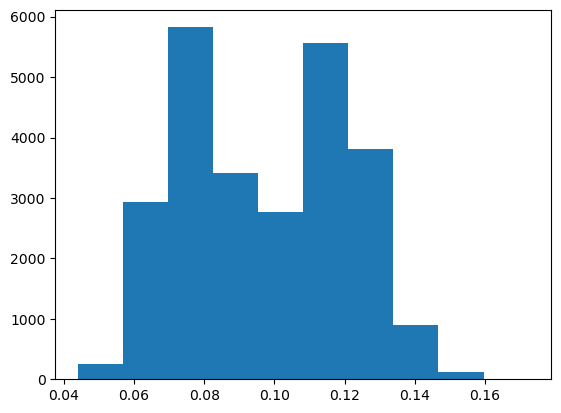

In [157]:
plt.hist(np.array(defense.avg_entropies).flatten())

(array([  17.,  128.,  894., 3248., 4422., 2891.,  924.,  234.,   44.,
           5.]),
 array([0.05856248, 0.06720403, 0.07584558, 0.08448713, 0.09312869,
        0.10177024, 0.11041179, 0.11905334, 0.12769489, 0.13633644,
        0.14497799]),
 <BarContainer object of 10 artists>)

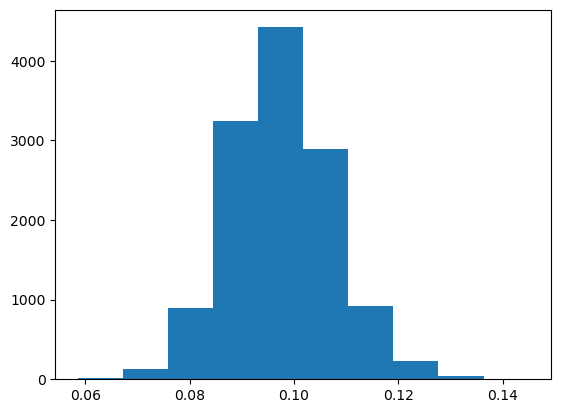

In [155]:
plt.hist(np.mean(np.array(defense.avg_entropies), axis=1))

(array([  39.,  286.,  980., 1018.,  588.,  830.,  887.,  380.,  101.,
          13.]),
 array([0.05132686, 0.06293432, 0.07454179, 0.08614926, 0.09775673,
        0.1093642 , 0.12097167, 0.13257914, 0.14418661, 0.15579408,
        0.16740155]),
 <BarContainer object of 10 artists>)

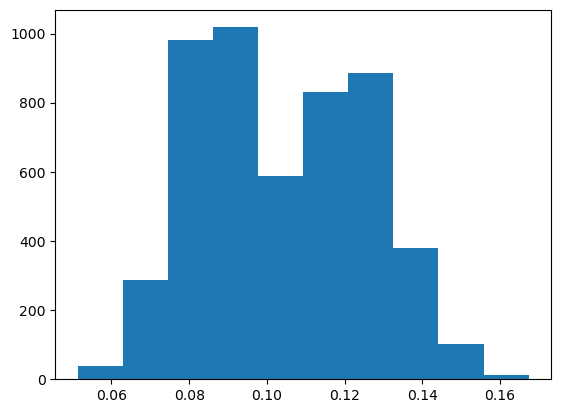

In [159]:
plt.hist(np.array(defense.avg_entropies)[np.where(np.array(result['is_poison'])==True)].flatten())

(array([ 243., 2804., 5061., 2159., 2065., 4678., 2869.,  550.,   57.,
           6.]),
 array([0.04395518, 0.05680452, 0.06965386, 0.0825032 , 0.09535254,
        0.10820188, 0.12105123, 0.13390057, 0.14674991, 0.15959925,
        0.17244859]),
 <BarContainer object of 10 artists>)

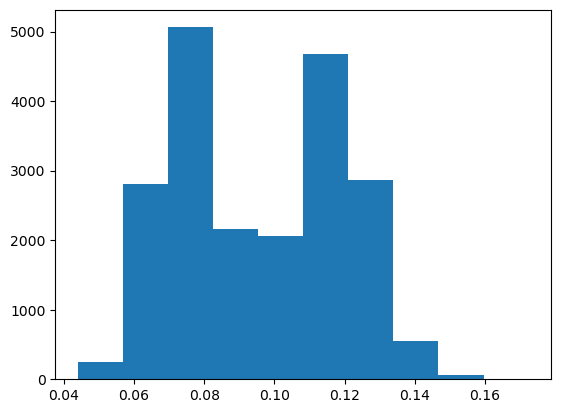

In [160]:
plt.hist(np.array(defense.avg_entropies)[np.where(np.array(result['is_poison'])==False)].flatten())

In [167]:
if config['log']['defense_remove_based_on'] == 'percentage' and config['log']['defense_percentage']>0.0:
    defense.identify_outliers_percentage(config['log']['defense_percentage']) 
    my_poison = defense.outliers if config['log']['defense_percentage'] > 0.0 else []
elif config['log']['defense_remove_based_on'] == 'threshold':
    defense.identify_outliers_threshold(config['log']['defense_threshold'])
    my_poison = defense.outliers
real_poison = set(np.where(np.array(result['is_poison'])==True)[0])
num_true_positive = len([i for i in my_poison if i in real_poison])
config['log']['defense_true_positive'] = num_true_positive/len(my_poison) if len(my_poison) > 0 else 0.0
config['log']['defense_poison_removal'] = num_true_positive/len(real_poison) if len(real_poison) > 0 else 0.0

In [168]:
config

{'root_path': '/home/user01/',
 'series_ID': 106,
 'series_desc': '\nfirst ideas to defend against attacks, having a trusted dataset\n',
 'log_path': '/home/user01/experiments/reports/106-nn-backdoor-idea1-mixup-0.65-mnist(1-7)-20-modify.json',
 'log': {'model': 'NN',
  'dataset': 'MNIST (1-7)',
  'task': 'binary classification',
  'pytorch_seed': 50,
  'numpy_seed': 50,
  'defense': 'idea1',
  'defense_combination_method': 'mixup',
  'defense_combination_samples': 50,
  'defense_remove_based_on': 'threshold',
  'defense_threshold': 0.1,
  'attack': 'backdoor',
  'num_backdoor_samples': 200,
  'method': 'modify',
  'space_dimension': 784,
  'img_width': 28,
  'img_height': 28,
  'bad_loss_percentage': 30,
  'num_repeats': 5,
  'accuracy_Test_before_defense': 0.9953767914932964,
  'accuracy_Train_before_defense': 0.9985164363238854,
  'attack_success_rate_test_before_defense': 1.0,
  'benign_accuracy_before_defense': 0.9981456178020691,
  'attack_success_rate_before_defense': 1.0,
  'de

# Train another model

In [ ]:
set(np.where(np.array(defense.avg_entropies).mean(axis=1)>=0.1)[0])

In [176]:
# outliers = set(defense.outliers) if ((config['log']['defense_remove_based_on']=='percentage' and config['log']['defense_percentage'] > 0.0) or (config['log']['defense_remove_based_on']=='threshold')) else []
outliers = set(np.where(np.array(defense.avg_entropies).mean(axis=1)>=0.12)[0])
x_sanitized = []
y_sanitized = []
sanitized_is_poison = []
for idx, (_x, _y, is_poison) in enumerate(zip(dataset.x_train, dataset.y_train, result['is_poison'])):
    if idx not in outliers:
        x_sanitized.append(_x)
        y_sanitized.append(_y)
        if is_poison:
            sanitized_is_poison.append(True)
        else:
            sanitized_is_poison.append(False)
x_sanitized = np.array(x_sanitized)
y_sanitized = np.array(y_sanitized)
sanitized_dataset = MyVectorDataset(x_sanitized.reshape(-1,1,config['log']['img_width'],config['log']['img_height']), y_sanitized)
sanitized_dataloader = DataLoader(sanitized_dataset, batch_size=config['batch_size'], shuffle=True)
model_sanitized = MNISTNET()
model_sanitized = model_sanitized.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sanitized.parameters(), lr=config['learning_rate']) #, weight_decay=1e-5
for epoch_num in range(1, config['num_epochs']+1):
    train_loop(sanitized_dataloader, model_sanitized, loss_fn, optimizer, epoch_num)
train_pred = make_prediction(model_sanitized.to('cpu'), x_sanitized)
test_pred = make_prediction(model_sanitized.to('cpu'), dataset.x_test)
config['log']['accuracy_Test'] = test_accuracy(dataset.y_test, test_pred)
config['log']['accuracy_Train'] = test_accuracy(y_sanitized, train_pred)
y_sanitized_pred = make_prediction(model_sanitized.to('cpu'), x_sanitized)
y_test_pred = make_prediction(model_sanitized.to('cpu'), dataset.x_test)
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    y_backdoor_pred = make_prediction(model_sanitized.to('cpu'), x_backdoor)
    config['log']['attack_success_rate_test'] = test_accuracy(y_backdoor, y_backdoor_pred)
config['log']['benign_accuracy'] = benign_accuracy(y_sanitized, y_sanitized_pred, sanitized_is_poison)
config['log']['attack_success_rate'] = attack_success_rate(y_sanitized, y_sanitized_pred, sanitized_is_poison)

 Epoch 100 - loss: -0.000000  [ 9600/12569] 

In [177]:
config

{'root_path': '/home/user01/',
 'series_ID': 106,
 'series_desc': '\nfirst ideas to defend against attacks, having a trusted dataset\n',
 'log_path': '/home/user01/experiments/reports/106-nn-backdoor-idea1-mixup-0.65-mnist(1-7)-20-modify.json',
 'log': {'model': 'NN',
  'dataset': 'MNIST (1-7)',
  'task': 'binary classification',
  'pytorch_seed': 50,
  'numpy_seed': 50,
  'defense': 'idea1',
  'defense_combination_method': 'mixup',
  'defense_combination_samples': 50,
  'defense_remove_based_on': 'threshold',
  'defense_threshold': 0.1,
  'attack': 'backdoor',
  'num_backdoor_samples': 200,
  'method': 'modify',
  'space_dimension': 784,
  'img_width': 28,
  'img_height': 28,
  'bad_loss_percentage': 30,
  'num_repeats': 5,
  'accuracy_Test_before_defense': 0.9953767914932964,
  'accuracy_Train_before_defense': 0.9985164363238854,
  'attack_success_rate_test_before_defense': 1.0,
  'benign_accuracy_before_defense': 0.9981456178020691,
  'attack_success_rate_before_defense': 1.0,
  'de

In [ ]:
# logger = JSONLogger(config['log_path'], config)
# logger.log()